# Notes

## Workflow
https://docs.google.com/document/d/1kIbxaqzdPZqHEJRxwuFCAar-G8W78VFRgDUEF5Mesjw/edit?invite=CI_q4swC&tab=t.0


## To-Do

- Analyse pré-exploratoire et préparation des données
    - Regarder l'équilibre des catégories avant le train-test-split ? Possible avec np.unique_counts(img_array) sur chaque image (se servir du multiprocessing)
    - Bien formaliser le code du train test split, l'inclure dans utils and constants

- Modele
    - Ajouter une visualisation entre courbe de loss train vs loss val + nom de la fonction de perte + dump
    - Finaliser les callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
    - fonction de visualisation sur la prédiction à affiner
    - plot des métriques à affiner + dump
    - En fonction des déséquilibres ajouter du sample_weight dans le modèle : https://www.tensorflow.org/tutorials/images/segmentation



# Future comms

##  **Les différents types de segmentation**
---

Un modèle de segmentation d'image génère en sortie une carte de segmentation où chaque pixel est classifié dans une catégorie spécifique. La structure de la couche de sortie dépend du type de segmentation :


### **1. Segmentation sémantique (ex : UNet, DeepLabV3)**
Chaque pixel appartient à une classe parmi un nombre fixe de classes.

- **Couche de sortie** : une convolution 2D avec autant de canaux que de classes (`Conv2D(num_classes, kernel_size=1)`).  
- **Tenseur de sortie** : `[batch_size, height, width, num_classes]`.  
- **Post-traitement** : on applique une fonction **softmax** (multiclasses) ou **sigmoïde** (binaire) pour obtenir des probabilités.  
- **Prédiction finale** : l'index du canal ayant la probabilité la plus élevée pour chaque pixel.
- **Métrique** : l'accuracy n'est pas une bonne métrique pour la segmentation, on utilise plutôt l'**Intersection over Union (IoU)** ou le **Dice Score**.
  - Pour les métriques, y_true est de forme sparse (ex : [batch_size, height, width]) et y_pred est de forme dense (ex : [batch_size, height, width, num_classes]).
- **Loss** : on utilise souvent la **cross-entropy** pour la segmentation multiclasse.
  - Pour des raisons computationnelles, on va préférer la fonction de perte `sparse_categorical_crossentropy` (attends y_true sous forme sparse (batch_size, height, width)) à `categorical_crossentropy` (attend y_true sous forme dense (batch_size, height, width, num_classes)) pour les problèmes de segmentation multiclasse.
  - Si on a des problèmes de déséquilibre de classes, il faut ajouter des samples weights dans la loss. (voir guide tensorflow)
  - L'argument from_logits=True dans la fonction de perte indique que la sorte `y_pred` est un vecteur de logits de size `num_classes` sans fonction d'activation.
  - L'agument from_logits=False indique que la sortie `y_pred` est un vecteur de probabilités de size `num_classes` avec une fonction d'activation (softmax).
  - L'argument class_weights permet de donner plus de poids à certaines classes pour compenser un déséquilibre de classes.


💡 **Exemple en segmentation binaire (ex : fond vs objet)**  
- Dernière couche : `Conv2D(1, kernel_size=1, activation="sigmoid")`  
- La sortie est de forme `[batch_size, height, width, 1]` avec des valeurs entre 0 et 1 (probabilité d'appartenir à la classe positive).

💡 **Exemple en segmentation multiclasse (ex : route, voiture, ciel, etc.)**  
- Dernière couche : `Conv2D(num_classes, kernel_size=1, activation="softmax")`  
- La sortie est `[batch_size, height, width, num_classes]`, et on prend `argmax` sur l'axe des classes.


### **2. Segmentation instance (ex : Mask R-CNN)**
Chaque instance d'un objet a un identifiant unique.

- **Sortie plus complexe** :  
  - Une **carte de segmentation** par objet détecté (`[batch_size, num_objects, height, width]`).  
  - Une **carte des scores** (`[batch_size, num_objects]`) pour indiquer la confiance de chaque masque.  
  - Une **boîte englobante** pour chaque instance.  

Ici, chaque pixel peut appartenir à plusieurs objets en même temps, contrairement à la segmentation sémantique.


### **Résumé**
| Type de segmentation | Forme de sortie | Activation | Post-traitement |
|----------------------|----------------|------------|-----------------|
| **Binaire** | `[batch, h, w, 1]` | Sigmoïde | Seuil (0.5) |
| **Multiclasse** | `[batch, h, w, num_classes]` | Softmax | `argmax` sur classes |
| **Instance** | `[batch, num_objects, h, w]` + scores | Variable | Seuil + NMS |

## **Présentation de UNET**

---

**UNet**, un modèle bien connu pour la segmentation sémantique. Ce modèle prend une image RGB de **256x512x3** et renvoie une carte de segmentation de **256x512x8** avec 8 classes.

U-Net is a CNN architecture used for most of the segmentation tasks. It consists of a contraction and expansion path which gives it the name UNet. The contraction path consists of a convolution layer, followed by ReLu followed by max-pooling layers. Along the contraction path, the features get extracted and the spatial information is reduced. Along the expansion path, a series of up convolutions along with concatenation of nigh resolution features are done from the contraction path. The final layer is a 1x1 convolution layer which gives the output of the same size as the input image. The output is a mask of the same size as the input image with each pixel having a value between 0 and 1. The final output is obtained by applying a threshold of 0.5 to the output mask.

### **Architecture du modèle :**
- Encodeur (feature extractor) basé sur **convolutions** + **max pooling** pour extraire les features.
- Décodeur avec **upsampling** (**upconv**) + **concatenation encodeur+decodeur** pour revenir à la résolution d'origine.
- Dernière couche avec **8 canaux** et activation **softmax** pour obtenir une distribution de probabilité sur les classes.

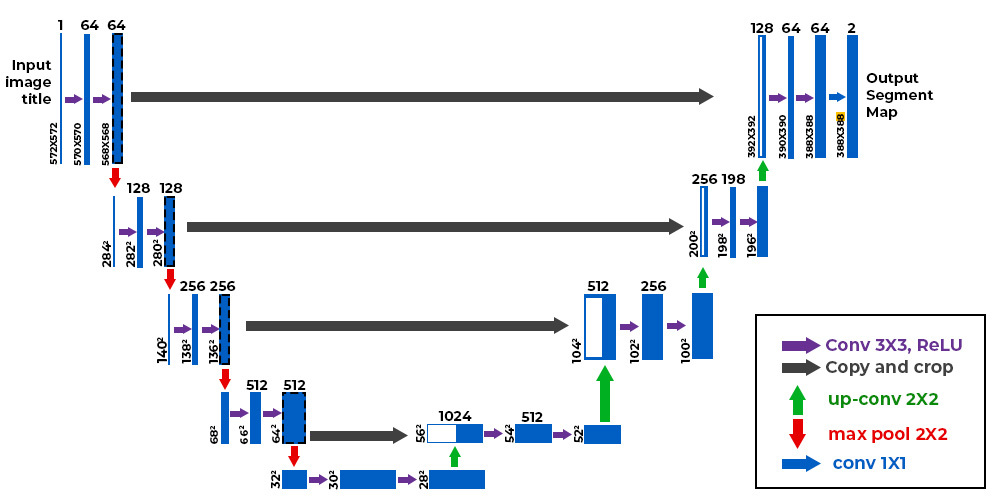


### **Explication de la sortie :**
- La dernière couche `Conv2D(8, (1,1), activation="softmax")` génère un tenseur **(256, 512, 8)**.
- Chaque pixel contient un vecteur de **8 probabilités** (une par classe).
- Pour obtenir l’image segmentée finale, on prend `argmax` sur l’axe des classes pour assigner chaque pixel à la classe la plus probable.


### **Résumé :**
✅ **Entrée** : Image `(256,512,3)`  
✅ **Sortie** : Carte de segmentation `(256,512,8)`  
✅ **Activation finale** : `softmax` pour classification pixel par pixel  
✅ **Post-traitement** : `argmax` pour obtenir la classe de chaque pixel  

## **Format des labels de sortie pour la segmentation**

---

Le format des labels dépend de la **fonction de perte** utilisée. Comme ta couche de sortie utilise une activation **softmax** et génère une sortie `(num_batches, 256, 512, 8)`, voici les deux options possibles :  


### **1️⃣ Labels sous forme d’index : `(num_batches, 256, 512)`**  
👉 **Format :** Chaque pixel est représenté par un entier correspondant à l'index de sa classe (0 à 7).  
👉 **Fonction de perte :** `SparseCategoricalCrossentropy(from_logits=False)`  

**Exemple d'un batch de labels :**  
```python
y_true.shape  # (num_batches, 256, 512), dtype=int
y_true[0, 100, 200]  # Exemple : 3 (classe 3 assignée au pixel (100,200))
```

✅ **Avantages** :
- Plus léger en mémoire.  
- Pas besoin de conversion avant l’entraînement.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```


### **2️⃣ Labels en one-hot : `(num_batches, 256, 512, 8)`**  
👉 **Format :** Chaque pixel est représenté par un vecteur de probabilité où une seule position est à 1 (one-hot encoding).  
👉 **Fonction de perte :** `CategoricalCrossentropy(from_logits=False)`  

**Exemple d'un pixel encodé en one-hot (classe 3)** :  
```python
[0, 0, 0, 1, 0, 0, 0, 0]  # Classe 3 activée
```

✅ **Avantages** :
- Permet de travailler avec des **poids de classes** si les classes sont déséquilibrées.  
- Peut être plus stable pour certaines architectures.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```
💡 Si tes labels sont sous forme `(num_batches, 256, 512)`, il faut les **convertir en one-hot** avant l’entraînement :  
```python
y_true_onehot = tf.one_hot(y_true, depth=8)  # Convertit (batch, 256, 512) → (batch, 256, 512, 8)
```



### **📌 Quelle approche choisir ?**  
✅ **Si tes labels sont stockés comme une image avec une seule valeur par pixel** → **`SparseCategoricalCrossentropy`** (option 1, plus simple).  
✅ **Si tu veux manipuler les probabilités ou ajuster les poids des classes** → **`CategoricalCrossentropy`** (option 2, one-hot).  

🚀 **Recommandation :** Utilise la première approche `(num_batches, 256, 512)` car elle est plus efficace en mémoire et plus simple à gérer.  


## Les métriques pour la segmentation d'images
---


Voici un tableau récapitulatif des applications des métriques d'évaluation en segmentation d'images :  

| **Applications**         | **Metrics Used**                | **Explanation**  |
|--------------------------|--------------------------------|-----------------|
| **Medical Imaging**      | Dice Coefficient, Hausdorff Distance | Assure une segmentation précise pour la détection de tumeurs, la délimitation des organes et l'identification d'anomalies, essentielle pour le diagnostic et le traitement. |
| **Autonomous Driving**   | IoU, Pixel Accuracy           | Évalue la capacité du modèle à identifier et localiser des objets (piétons, véhicules, panneaux) pour garantir une navigation sécurisée des véhicules autonomes. |
| **Satellite and Aerial Imaging** | IoU, Boundary F1 Score | Analyse la classification du couvert terrestre, la planification urbaine et la surveillance environnementale, en évaluant la précision des régions segmentées et des contours. |
| **Agriculture**          | Dice Coefficient, Precision   | Mesure la segmentation des zones de culture saines et malades, facilitant la gestion des cultures et l’optimisation des rendements. |
| **Augmented Reality (AR)** | IoU, Pixel Accuracy         | Garantit un alignement précis des objets virtuels sur les surfaces du monde réel pour améliorer l’expérience utilisateur. |

Ce tableau synthétise les principales métriques utilisées selon les applications et leur importance.

## Formulas


Voici un tableau récapitulatif des formules des principales métriques d'évaluation en segmentation d'images :  

| **Métrique**           | **Formule**  |
|------------------------|-------------|
| **Dice Coefficient**   | \( \frac{2TP}{2TP + FP + FN} \) |
| **IoU (Intersection over Union)** | \( \frac{TP}{TP + FP + FN} \) |
| **Pixel Accuracy**     | \( \frac{TP + TN}{TP + TN + FP + FN} \) |
| **Precision**         | \( \frac{TP}{TP + FP} \) |
| **Recall (Sensitivity)** | \( \frac{TP}{TP + FN} \) |
| **F1 Score**          | \( \frac{2 \times Precision \times Recall}{Precision + Recall} \) |
| **Boundary F1 Score** | Basé sur la F1 Score mais appliqué aux contours segmentés (requiert un calcul spatial des frontières) |
| **Hausdorff Distance** | \( \max \{ \sup_{a \in A} \inf_{b \in B} d(a,b), \sup_{b \in B} \inf_{a \in A} d(a,b) \} \) (distance maximale entre les frontières de la segmentation et de la vérité terrain) |

Ces formules utilisent les termes :
- **TP (True Positives)** : pixels correctement classés comme appartenant à la classe cible.
- **TN (True Negatives)** : pixels correctement classés comme n'appartenant pas à la classe cible.
- **FP (False Positives)** : pixels incorrectement classés comme appartenant à la classe cible.
- **FN (False Negatives)** : pixels incorrectement classés comme n'appartenant pas à la classe cible.

## Critiques des métriques
Pour évaluer la qualité de la segmentation d'images, on utilise des métriques spécifiques qui comparent les prédictions du modèle aux vrais labels en mesurant la qualité de l'overlapping entre le y_pred et y_true. Voici les principales métriques utilisées pour évaluer la segmentation d'images :
- Pixel accuracy pas recommande lorsquil a une  classe dominante comme le background. prends en compte tp et tn
    - (tn+tp)/(tn+fp+fn+fp)


- precision, recall & dice (f1 Sørensen–Dice index) ok (tp dans le numérateur)
    - p (tp)/(tp+fp) : Precision measures the proportion of true positive pixels among all pixels classified as positive by the model
    - r (tp)/(tp+fn) : Recall, on the other hand, measures the proportion of true positive pixels that were correctly identified out of all actual positive pixels
    - d (tp+tp)/(tp+tp+fn+fp) : Dice is the harmonic mean of precision and recall. It is a common metric for segmentation tasks because it is more sensitive to small objects than accuracy.
    - High precision indicates that the model has a low false positive rate, while high recall indicates a low false negative rate.

- IoU, Jaccard Index : best > tp (intersect) dans le numerateur et union dans le diviseur (diviseur tout sauf tn)
    - (tp)/(tp+fn+fp)
    - dice harmonic mean
    - iou > penalize more fp and add a SMOOTH factor to avoid division by 0 and compute IoU for each class absent in the image

- Soft (on probabilities without argmax) / hard (with argmax as ohe)


## Focus on Jackard Index & Dice Coefficient

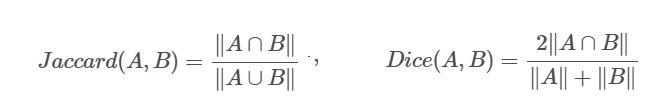

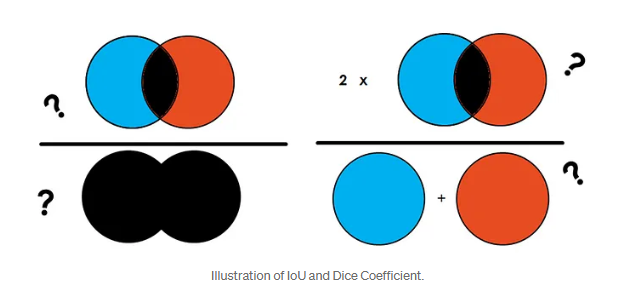


- A gauche, Interesection / Union : IoU = TP / (TP + FP + FN)
- A droite, Dice : Dice (Harmonic mean between recall and precision) = 2 * TP / (2 * TP + FP + FN)

## JACCARD CALCULATION

Let’s calculate the ship IoU first. We assume the total area of the image is 100 (100 pixels). First, let’s think about the ships’ overlap. We can pretend that we move the predicted segmentation (left) directly above the ground truth (right), and see if there are any ship pixels that overlap. Since there are no pixels that are classified as ships by the model, there are 0 overlapping ship pixels.

Union consists of all of the pixels classified as ships from both images, minus the overlap/intersection. In this case, there are 5 pixels (this is an arbitrary number choice) that are classified as ships total. Subtract the overlap/intersection which is 0 to get 5 as the area of union. After doing the calculations, we learn that the IoU is merely 47.5%! See the calculation below.

Here is the detailed calculation:

Ships: Area of Overlap = 0, Area of Union = (5+0)-0 =5

Area of Overlap/Area of Union = 0%

Now for the black background, we do the same thing.

Background: Area of Overlap = 95, Area of Union = (95+100)–95 = 100

Area of Overlap/Area of Union =95%

Mean IoU = (Ships + Background)/2 = (0%+95%)/2 = 47.5%

## DICE CALCULATION

Total Number of Pixels for both images combined = 200

Ships: Area of Overlap = 0

(2 * Area of Overlap)/(total pixels combined) = 0/200 = 0

Background: Area of Overlap = 95

(2 * Area of Overlap)/(total pixels combined) = 95*2/200 = 0.95

Dice = (Ships + Background)/2 = (0%+95%)/2 = 47.5%

## Others metrics

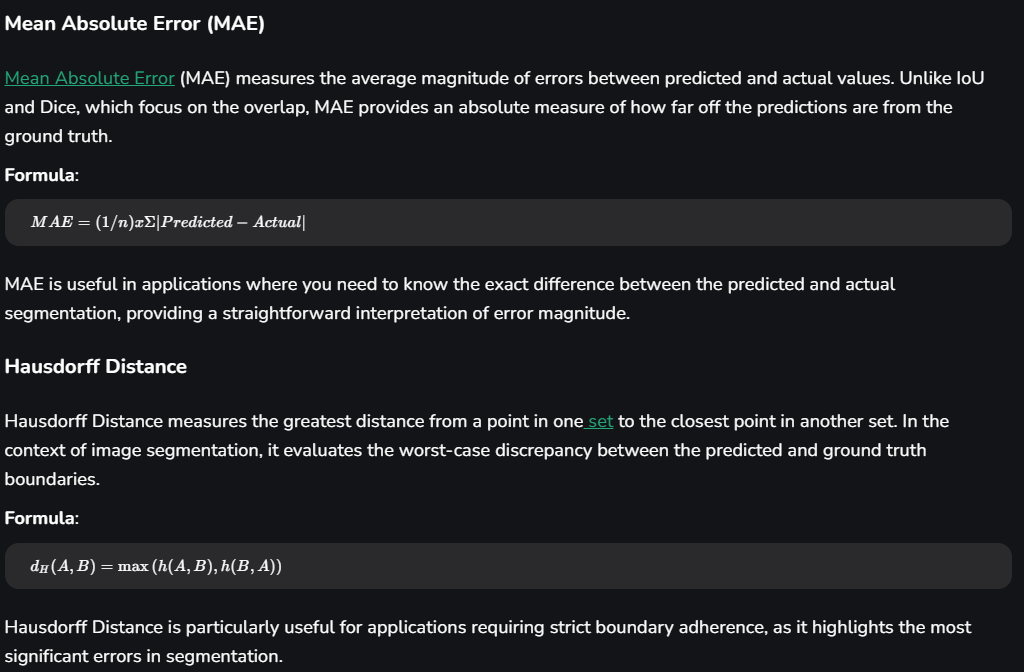

## **ConvNet Architectures**
We have seen that Convolutional Networks are commonly made up of only three layer types: CONV, POOL (we assume Max pool unless stated otherwise) and FC (short for fully-connected). We will also explicitly write the RELU activation function as a layer, which applies elementwise non-linearity. In this section we discuss how these are commonly stacked together to form entire ConvNets.

- Converting FC layers to CONV layers
    - It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between FC and CONV layers:


### 📌 **1. Composants d'un CNN**
Un CNN est constitué de plusieurs types de couches :

#### **🔹 Couches Convolutives (Conv Layer)**
- Appliquent des filtres (kernels) pour extraire des **caractéristiques locales**.
- Génèrent des **cartes de caractéristiques (feature maps)**.
- Hyperparamètres : **taille du kernel, stride, padding**.

#### **🔹 Couches d'Activation**
- Introduisent la **non-linéarité**.
- Fonction la plus courante : **ReLU** (Rectified Linear Unit).

#### **🔹 Couches de Pooling (Sous-échantillonnage)**
- Réduisent la **dimensionnalité** et la **sensibilité au bruit**.
- Types :
  - **Max Pooling** : prend la valeur maximale d’une région.
  - **Average Pooling** : prend la moyenne.

#### **🔹 Couches Fully Connected (Dense)**
- Transforme les cartes de caractéristiques en un **vecteur** pour la classification.
- Dernière couche : souvent **Softmax** pour la classification multi-classes.

---

### 🔥 **2. Architectures Populaires de CNN**
Voici quelques architectures CNN célèbres :

#### **1️⃣ LeNet-5 (1998)**
- Premier CNN utilisé pour la reconnaissance de chiffres manuscrits.
- **Structure** :
  - Conv → Pool → Conv → Pool → Dense → Output
- Très simple mais efficace pour de petites images (comme MNIST).

#### **2️⃣ AlexNet (2012)**
- A révolutionné la vision par ordinateur en gagnant ImageNet.
- **Structure** :
  - 5 Convolution + Pooling → 3 Fully Connected
- Introduit **ReLU**, **Dropout** et **GPU training**.

#### **3️⃣ VGG (2014)**
- Approche modulaire avec des **kernels 3x3** pour toutes les convolutions.
- **Variantes : VGG-16, VGG-19**.
- Très profond mais lourd en calcul.

#### **4️⃣ GoogLeNet (Inception) (2014)**
- Introduit les **Inception Blocks** : différentes tailles de filtres en parallèle.
- **Moins de paramètres** qu’AlexNet ou VGG grâce à l’utilisation de convolutions 1x1.

#### **5️⃣ ResNet (2015)**
- Introduit les **skip connections (résiduals)**.
- Résout le problème du **gradient vanishing** dans les réseaux profonds.
- Variantes : **ResNet-18, ResNet-34, ResNet-50, ResNet-101**.

#### **6️⃣ EfficientNet (2019)**
- Basé sur une optimisation du **scaling** (taille des filtres, profondeur, résolution).
- Très performant avec moins de calculs que ResNet.

---

### 🚀 **3. Conception d’un CNN en TensorFlow/Keras**
Un exemple de CNN simple avec **Keras** :

```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes pour classification
])

model.summary()
```

---

### 🎯 **4. Choisir une Architecture CNN**
| **Modèle**   | **Avantages** | **Inconvénients** |
|-------------|--------------|----------------|
| **LeNet-5**  | Simple et rapide | Mauvaise généralisation sur images complexes |
| **AlexNet**  | Performant sur grands datasets | Très lourd en calcul |
| **VGG**      | Facile à implémenter | Nombre de paramètres énorme |
| **GoogLeNet** | Moins de paramètres | Complexe à implémenter |
| **ResNet**   | Permet des réseaux très profonds | Plus gourmand en mémoire |
| **EfficientNet** | Performant et léger | Architecture optimisée difficile à ajuster |


## Conversion des couches FC et CONV

---

### 🔹 **1. Passage de l'extraction de caractéristiques à la classification**
- **Les couches convolutives** apprennent des **descripteurs locaux** (bords, textures, motifs).
- **Les couches fully connected** interprètent ces descripteurs pour faire une **prédiction globale**.
- Convertir une couche conv en dense permet de **transformer les cartes de caractéristiques en un vecteur de décision**.


### 🔹 **2. Compatibilité avec un classifieur classique**
- **Les couches convolutives génèrent des matrices 3D** (hauteur, largeur, canaux).
- **Les couches fully connected prennent des vecteurs en entrée**.
- La conversion (via un `Flatten()`) permet d'utiliser un **classifieur dense** comme Softmax ou une MLP.

🔹 **Exemple en TensorFlow/Keras** :
```python
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),  # Conversion de la sortie convolutive en vecteur
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Classification sur 10 classes
])
```
- La couche `Flatten()` convertit la sortie des convolutions en **un vecteur 1D** utilisable par les couches `Dense`.

---

### 🔹 **3. Réduction de la dimensionnalité et adaptation aux tâches**
- Dans certains cas, une conversion en fully connected permet de **réduire la taille des paramètres** et d'ajuster l'architecture.
- Exemple : en **transformant les cartes de caractéristiques en un vecteur plus petit**, on peut mieux généraliser et éviter le surajustement.

---

### 🔹 **4. Simulation d’une convolution avec une couche Dense**
- Une **couche convolutionnelle peut être réécrite comme une couche dense** si l'on ignore le partage de poids.
- Exemple : une **convolution 1x1 avec autant de filtres que d'entrées** est **équivalente à une couche dense**.

---

### 🔹 **5. Réduction du besoin en mémoire et calcul**
- **Transformer une convolution en fully connected** peut parfois réduire la mémoire et accélérer l’inférence.
- Exemple : Dans certains modèles mobiles (**MobileNet, SqueezeNet**), une **dernière convolution 1x1 remplace les couches fully connected** pour réduire le nombre de paramètres.

---

### 🎯 **Conclusion**
✅ **Transformer une couche convolutive en fully connected** permet :
- D’adapter les sorties convolutives pour une tâche de classification.
- D’obtenir un vecteur compatible avec des classifieurs denses.
- De modifier l’architecture pour réduire la complexité.

👉 **Alternatives modernes** : Au lieu de `Flatten()`, certains modèles utilisent **Global Average Pooling (GAP)** pour obtenir une sortie plus robuste et compacte :

```python
layers.GlobalAveragePooling2D()
```

## Pooling vs Convolution avec Stride

---

### 🔹 **1. Différences entre Pooling et Convolution avec Stride**
| **Critère** | **Pooling (Max/Average)** | **Convolution avec Stride** |
|------------|--------------------------|----------------------------|
| **Principe** | Sous-échantillonne l’image en prenant un maximum (max pooling) ou une moyenne (average pooling). | Utilise des filtres qui glissent sur l’image avec un pas (`stride > 1`), supprimant ainsi des pixels. |
| **Perte d’information** | Peut perdre des détails importants (surtout avec max pooling). | Garde plus d’informations car la convolution apprend des poids adaptés. |
| **Paramètres appris** | Aucun (opération fixe). | Oui (les poids du filtre sont optimisés pendant l’entraînement). |
| **Consommation mémoire** | Moins coûteux (aucun paramètre à apprendre). | Plus gourmand en calculs (paramètres à optimiser). |
| **Effet sur le gradient** | Peut causer des pertes d’informations abruptes et un gradient moins stable. | Lisse mieux la propagation du gradient grâce aux poids appris. |

---

### 🔥 **2. Pourquoi utiliser une convolution avec stride à la place du pooling ?**
#### ✅ **Avantages de la convolution avec stride :**
1. **Meilleure optimisation** :  
   - Les **poids du filtre** sont appris, contrairement au pooling qui est une opération fixe.
   - Permet au modèle d’optimiser l’extraction de caractéristiques sans perdre trop d’informations.
   
2. **Propagation du gradient améliorée** :  
   - Moins de perte d’information abrupte que le max pooling.
   - Réduit le risque de disparition du gradient dans les réseaux très profonds.

3. **Moins d’opérations distinctes** :  
   - Évite d’avoir une couche supplémentaire pour le pooling → simplifie l’architecture.

4. **Utilisé dans les architectures modernes** :  
   - **ResNet, MobileNet, DenseNet** préfèrent **les convolutions avec stride** au lieu des **poolings classiques**.

---

### ⚠️ **3. Mais faut-il complètement éviter le pooling ?**
Pas forcément ! Il existe des cas où le **pooling reste utile** :

1. **Max pooling pour une meilleure invariance aux translations**  
   - Le max pooling **réduit la sensibilité aux petits déplacements** dans l’image.
   - Utile pour **des tâches de reconnaissance d’objets** où la position exacte n’est pas importante.

2. **Average pooling dans les architectures récentes**  
   - Le **Global Average Pooling (GAP)** est souvent utilisé pour réduire les dimensions tout en gardant une bonne généralisation :
   ```python
   layers.GlobalAveragePooling2D()
   ```
   - Utilisé dans **ResNet, MobileNet** pour éviter des couches fully connected trop grandes.

---

### 🎯 **4. Recommandation selon les cas**
| **Cas d’usage** | **Pooling classique** | **Convolution avec stride** |
|----------------|----------------------|----------------------------|
| **Tâches classiques (classification d’images)** | ✅ Max Pooling souvent efficace. | 🚫 Pas toujours nécessaire. |
| **Modèles modernes (MobileNet, ResNet, EfficientNet)** | 🚫 Souvent remplacé par GAP. | ✅ Strided Convolution préférable. |
| **Besoin d’invariance aux translations** | ✅ Max Pooling utile. | 🚫 Moins efficace. |
| **Optimisation des calculs sur GPU** | 🚫 Pooling moins flexible. | ✅ Strided Convolution plus efficace sur certains hardware. |

---

### 🎯 **Conclusion**
👉 **Remplacer le pooling par une convolution avec stride est souvent bénéfique**, mais pas toujours obligatoire.  
👉 Les architectures modernes tendent à privilégier **les convolutions avec stride ou le Global Average Pooling (GAP)** au lieu du max pooling.  
👉 **Si tu veux un réseau plus optimisé et entraînable, évite le pooling et favorise les convolutions avec stride.** 🚀  

Tu travailles sur quel type de CNN ? 😊

## CONV LAYER & POOL LAYER Input to Output

### CONV LAYER FILTERS (K) AND STRIDE (S) AND PADDING (P) AND SPATIAL EXTENT (F) vs W x H x D (input) 
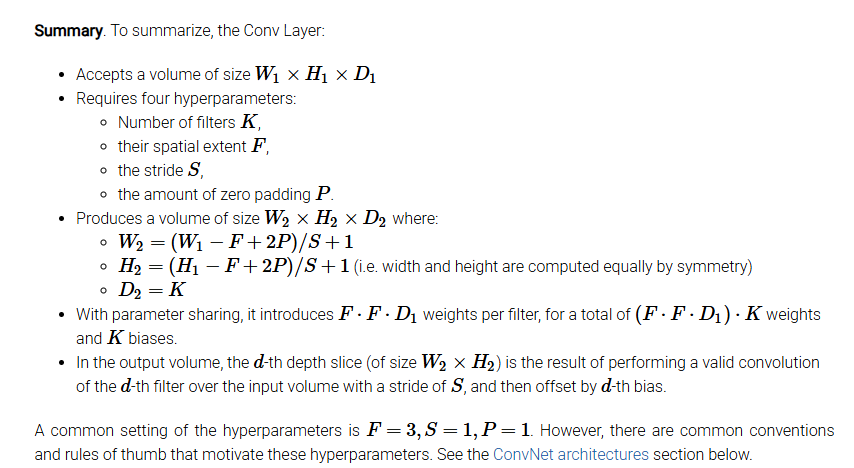

### POOL LAYER FILTERS (K) AND STRIDE (S) AND SPATIAL EXTENT (F) vs W x H x D (input)
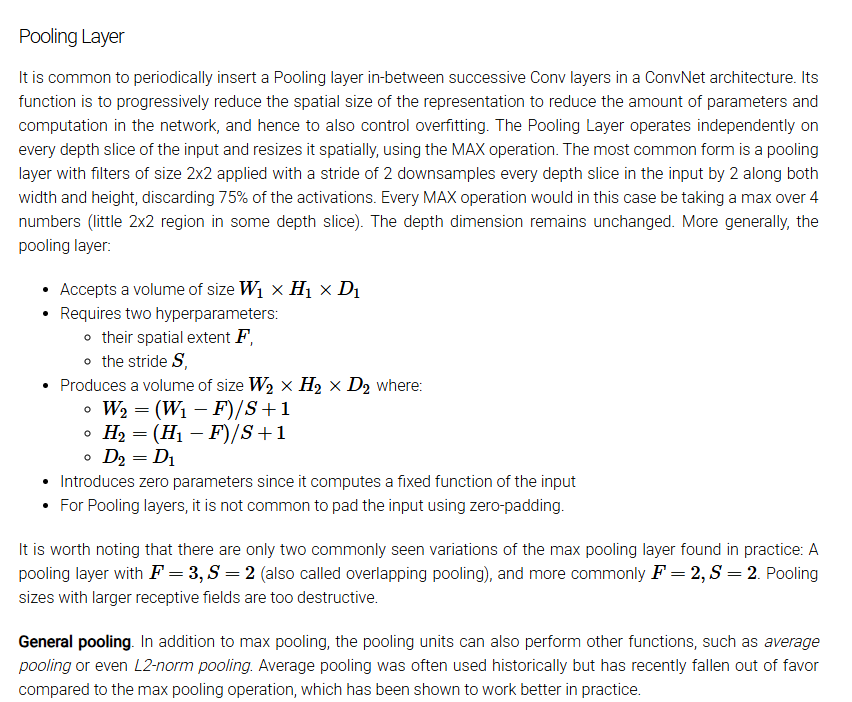

## **Loss & Optimizer**
---

Optimizer that implements the AdamW algorithm.

AdamW optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments with an added method to decay weights per the techniques discussed in the paper, 'Decoupled Weight Decay Regularization' by Loshchilov, Hutter et al., 2019.

According to Kingma et al., 2014, the underlying Adam method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

https://arxiv.org/pdf/1711.05101

Oui, **l'accumulation de gradients** peut indirectement améliorer la généralisation, mais ce n'est pas automatique. Voici pourquoi :  

✅ **Moins de bruit dans les gradients** : Un petit batch produit des gradients plus bruyants, ce qui peut rendre l'optimisation instable. L'accumulation de gradients lisse ces variations et rend l'entraînement plus stable.  

✅ **Effet similaire à un plus grand batch** : En accumulant les gradients sur plusieurs mini-batchs, on se rapproche du comportement d’un entraînement avec un grand batch effectif, qui peut améliorer la convergence et la stabilité.  

🚨 **Mais attention** :  
- Une généralisation optimale dépend aussi d'autres facteurs comme **le taux d’apprentissage, la régularisation (dropout, weight decay), et la diversité des données**.  
- Accumuler trop de gradients peut **réduire la stochasticité**, ce qui peut parfois **nuire à la généralisation** (d'où l’intérêt des petits batchs pour éviter un sur-apprentissage).  

En gros, c’est **un bon compromis** pour stabiliser l'entraînement avec un petit batch, mais il ne remplace pas les autres techniques d'amélioration de la généralisation.  

Tu cherches à optimiser un modèle précis avec cette approche ? 😊